# Online Fraud Detection Analysis
This notebook performs advanced fraud detection on the `onlinefraud.csv` dataset, including feature engineering, exploratory data analysis (EDA), XGBoost modeling, and anomaly detection with Isolation Forest.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
import pickle

## Load the Dataset

In [21]:
dtypes = {
    'type': 'category',  # Use category dtype for type
    'amount': 'float32',
    'oldbalanceOrg': 'float32',
    'newbalanceOrig': 'float32',
    'oldbalanceDest': 'float32',
    'newbalanceDest': 'float32',
    'isFraud': 'int8'
}
data = pd.read_csv("onlinefraud.csv", dtype=dtypes)
data = data.sample(frac=0.1, random_state=42)  # Sample 10% to manage memory
print(f"Sampled data shape: {data.shape}")
data.head()

Sampled data shape: (636262, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3737323,278,CASH_IN,3.302184e+05,C632336343,20866.0,3.510844e+05,C834976624,4.524196e+05,1.222011e+05,0,0
264914,15,PAYMENT,1.164708e+04,C1264712553,30370.0,1.872292e+04,M215391829,0.000000e+00,0.000000e+00,0,0
85647,10,CASH_IN,1.522642e+05,C1746846248,106589.0,2.588532e+05,C1607284477,2.013030e+05,4.903880e+04,0,0
5899326,403,TRANSFER,1.551761e+06,C333676753,0.0,0.000000e+00,C1564353608,3.198360e+06,4.750120e+06,0,0
2544263,206,CASH_IN,7.817230e+04,C813403091,2921331.5,2.999504e+06,C1091768874,4.158219e+05,3.376496e+05,0,0


## Step 1: Feature Engineering

In [23]:
# Feature engineering
data['balance_diff_orig'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['balance_diff_dest'] = data['oldbalanceDest'] - data['newbalanceDest']
data['is_orig_balance_zero'] = (data['oldbalanceOrg'] == 0).astype('int8')
data['is_dest_balance_zero'] = (data['newbalanceDest'] == 0).astype('int8')
data['amount_to_orig_balance'] = np.where(data['oldbalanceOrg'] > 0, data['amount'] / data['oldbalanceOrg'], 0).astype('float32')
data['amount_to_dest_balance'] = np.where(data['oldbalanceDest'] > 0, data['amount'] / data['oldbalanceDest'], 0).astype('float32')
data['type_code'] = data['type'].cat.codes  # Convert type to integer codes

# Define features (excluding step, hour_of_day, day_of_week)
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
            'balance_diff_orig', 'balance_diff_dest', 'is_orig_balance_zero', 
            'is_dest_balance_zero', 'amount_to_orig_balance', 'amount_to_dest_balance', 
            'type_code']
X = data[features]
y = data['isFraud']

# Display result
print("Feature engineering completed:")
data[features].head()

Feature engineering completed:


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,balance_diff_orig,balance_diff_dest,is_orig_balance_zero,is_dest_balance_zero,amount_to_orig_balance,amount_to_dest_balance,type_code
3737323,3.302184e+05,20866.0,3.510844e+05,4.524196e+05,1.222011e+05,-330218.406250,3.302184e+05,0,0,15.825669,0.729894,0
264914,1.164708e+04,30370.0,1.872292e+04,0.000000e+00,0.000000e+00,11647.080078,0.000000e+00,0,1,0.383506,0.000000,3
85647,1.522642e+05,106589.0,2.588532e+05,2.013030e+05,4.903880e+04,-152264.203125,1.522642e+05,0,0,1.428517,0.756393,0
5899326,1.551761e+06,0.0,0.000000e+00,3.198360e+06,4.750120e+06,0.000000,-1.551760e+06,1,0,0.000000,0.485174,4
2544263,7.817230e+04,2921331.5,2.999504e+06,4.158219e+05,3.376496e+05,-78172.500000,7.817231e+04,0,0,0.026759,0.187995,0


## Step 2: Exploratory Data Analysis (EDA)

Fraud Distribution:
 isFraud
0    0.998716
1    0.001284
Name: proportion, dtype: float64


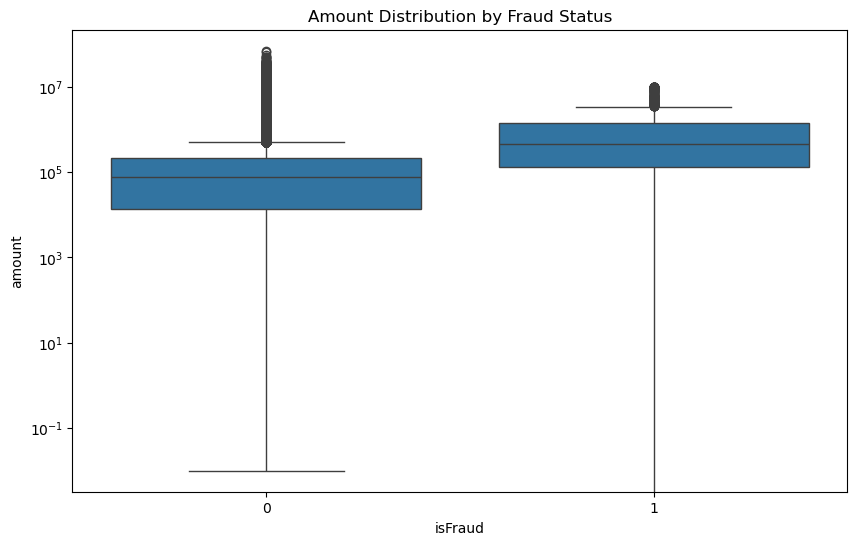

In [30]:
# Fraud distribution
print("Fraud Distribution:\n", data['isFraud'].value_counts(normalize=True))

# Amount distribution by fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='isFraud', y='amount', data=data)
plt.title("Amount Distribution by Fraud Status")
plt.yscale('log')  # Log scale due to large range in amounts
plt.show()

## Step 3: Train/Test Split

In [25]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

print("X_train dtypes:\n", X_train.dtypes)
print("y_train dtype:", y_train.dtype)

Training set size: (509009, 12)
Test set size: (127253, 12)
X_train dtypes:
 amount                    float32
oldbalanceOrg             float32
newbalanceOrig            float32
oldbalanceDest            float32
newbalanceDest            float32
balance_diff_orig         float32
balance_diff_dest         float32
is_orig_balance_zero         int8
is_dest_balance_zero         int8
amount_to_orig_balance    float32
amount_to_dest_balance    float32
type_code                    int8
dtype: object
y_train dtype: int8


## Step 4: Advanced Modeling with XGBoost

In [ ]:
# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

# Train XGBoost model
model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

/home/meekhumor/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:29:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training and predictions completed.
First 5 predictions: [0 0 0 0 0]
First 5 probabilities: [4.4159611e-07 3.9777797e-07 7.6704180e-07 6.5208659e-12 2.1784949e-09]
Model saved as 'xgboost_model.pkl'.


## Step 5: Save Models

In [ ]:
with open("xgboost_model_no_step.pkl", "wb") as file:
    pickle.dump(model, file)
print("Model saved as 'xgboost_model_no_step.pkl'.")

## Step 6: Model Prediction

In [28]:
# Load the trained model
with open("xgboost_model_no_step.pkl", "rb") as file:
    model = pickle.load(file)

# Define the features the model was trained on
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
            'balance_diff_orig', 'balance_diff_dest', 'is_orig_balance_zero', 
            'is_dest_balance_zero', 'amount_to_orig_balance', 'amount_to_dest_balance', 
            'type_code']

# Mapping for type to type_code (based on typical fraud dataset categories)
type_mapping = {'CASH_IN': 0, 'CASH_OUT': 1, 'DEBIT': 2, 'PAYMENT': 3, 'TRANSFER': 4}

# Manual input for prediction
print("Enter transaction details:")
transaction_type = input("Transaction Type (CASH_IN, CASH_OUT, DEBIT, PAYMENT, TRANSFER): ").upper()
amount = float(input("Amount (e.g., 1000.0): "))
oldbalanceOrg = float(input("Origin Balance Before (e.g., 5000.0): "))
newbalanceOrig = float(input("Origin Balance After (e.g., 4000.0): "))
oldbalanceDest = float(input("Destination Balance Before (e.g., 0.0): "))
newbalanceDest = float(input("Destination Balance After (e.g., 1000.0): "))

# Create a DataFrame with raw input
raw_data = pd.DataFrame({
    'amount': [amount],
    'oldbalanceOrg': [oldbalanceOrg],
    'newbalanceOrig': [newbalanceOrig],
    'oldbalanceDest': [oldbalanceDest],
    'newbalanceDest': [newbalanceDest]
})

# Feature engineering (matching training process, no step)
raw_data['balance_diff_orig'] = raw_data['oldbalanceOrg'] - raw_data['newbalanceOrig']
raw_data['balance_diff_dest'] = raw_data['oldbalanceDest'] - raw_data['newbalanceDest']
raw_data['is_orig_balance_zero'] = (raw_data['oldbalanceOrg'] == 0).astype(int)
raw_data['is_dest_balance_zero'] = (raw_data['newbalanceDest'] == 0).astype(int)
raw_data['amount_to_orig_balance'] = np.where(raw_data['oldbalanceOrg'] > 0, raw_data['amount'] / raw_data['oldbalanceOrg'], 0)
raw_data['amount_to_dest_balance'] = np.where(raw_data['oldbalanceDest'] > 0, raw_data['amount'] / raw_data['oldbalanceDest'], 0)
raw_data['type_code'] = [type_mapping[transaction_type]]  # Convert type to type_code directly

# Ensure all expected columns are present and in the right order
new_data = raw_data[features]

# Make prediction
prediction = model.predict(new_data)[0]
probability = model.predict_proba(new_data)[0, 1]

# Output result
print("\nPrediction Result:")
print(f"Predicted Class: {prediction} (0 = No Fraud, 1 = Fraud)")
print(f"Fraud Probability: {probability:.4f}")

Enter transaction details:



Prediction Result:
Predicted Class: 1 (0 = No Fraud, 1 = Fraud)
Fraud Probability: 0.9803
